# Calculating Forest Loss at the Ethnologue Polygon Level

In [4]:
import os
import ee
import geemap 
import pandas as pd

#ee.Authenticate()
ee.Initialize()

In [5]:
# Define region to view (Peru/Brazil Amazon)
world_bbox = ee.Geometry.BBox(-180, -85, 180, 85)

# Load the treecover2000 band
treecover = ee.Image("UMD/hansen/global_forest_change_2024_v1_12").select("treecover2000")

# Visualization settings
vis_params = {
    'min': 0,
    'max': 100,
    'palette': ['ffffff', '006400']
}

# Create map
Map = geemap.Map(center=[-7.5, -72.5], zoom=6)
Map.addLayer(treecover.clip(world_bbox), vis_params, 'Treecover 2000')
Map.addLayer(world_bbox, {}, 'Region')
Map

Map(center=[-7.5, -72.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [6]:
# # Export to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=treecover,
#     description='treecover2000_100m_30m',
#     folder='GEE_exports',
#     fileNamePrefix='treecover2000_100m_30m',
#     region=world_bbox,
#     scale=100,
#     maxPixels=1e13
# )

# task.start()

In [7]:
# # Load the treecover2000 band
# treeloss = ee.Image("UMD/hansen/global_forest_change_2024_v1_12").select("loss")

# # Export to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=treeloss,
#     description='treeloss_100m_30m',
#     folder='GEE_exports',
#     fileNamePrefix='treeloss_100m_30m',
#     region=world_bbox,
#     scale=100,
#     maxPixels=1e13
# )

# task.start()

### NOTE: see the progress of exports at [GEE Task Manager](https://code.earthengine.google.com/tasks)

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

import mapclassify

from rapidfuzz import process, fuzz

from shapely.geometry import Point

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
from glob import glob
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [3]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/RAships/2-Folklore-Nathan-Project/EA-Maps-Nathan-project/Measures_work")

# Set file paths
poscol_path = base_path / "data" / "raw" / "ethnologue" / "ancestral_characteristics_database_language_level" / "Ethnologue_16_shapefile" / "langa_no_overlap_biggest_clean.shp"

data_path = base_path / "data" / "interim"
maps_path = base_path / "maps" / "raw"
hansen_path = base_path / "maps" / "raw" / "Hansen_forest"

export_path = base_path / "maps" / "interim" / "ethnologue_parts"

In [4]:
# Read the shapefiles and CSV files
ethnologue = gpd.read_file(poscol_path)

# Keep only relevant columns
ethnologue = ethnologue[["ID", "geometry"]]

print(f"Number of features: {len(ethnologue)}") 

Number of features: 7087


In [ ]:
# List all the raster files 
raster_files = glob(str(hansen_path / "treecover" / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

from rasterio.merge import merge

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

Found raster files: ['C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treecover\\treecover2000_100m_30m-0000000000-0000000000.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treecover\\treecover2000_100m_30m-0000000000-0000065536.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treecover\\treecover2000_100m_30m-0000000000-0000131072.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treecover\\treecover2000_100m_30m-0000000000-0000196608.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treecover\\treecover2000_100m_30m-0000000000-0000262144.tif', 'C:\\Users\\juami\\Dropb

In [10]:
# Check CRS of each input raster
for i, src in enumerate(src_files_to_mosaic):
    print(f"Raster {i} CRS:", src.crs)

ethnologue = ethnologue.to_crs(src_files_to_mosaic[0].crs)

Raster 0 CRS: EPSG:4326
Raster 1 CRS: EPSG:4326
Raster 2 CRS: EPSG:4326
Raster 3 CRS: EPSG:4326
Raster 4 CRS: EPSG:4326
Raster 5 CRS: EPSG:4326
Raster 6 CRS: EPSG:4326
Raster 7 CRS: EPSG:4326
Raster 8 CRS: EPSG:4326
Raster 9 CRS: EPSG:4326
Raster 10 CRS: EPSG:4326
Raster 11 CRS: EPSG:4326
Raster 12 CRS: EPSG:4326
Raster 13 CRS: EPSG:4326
Raster 14 CRS: EPSG:4326
Raster 15 CRS: EPSG:4326
Raster 16 CRS: EPSG:4326
Raster 17 CRS: EPSG:4326
Raster 18 CRS: EPSG:4326
Raster 19 CRS: EPSG:4326
Raster 20 CRS: EPSG:4326


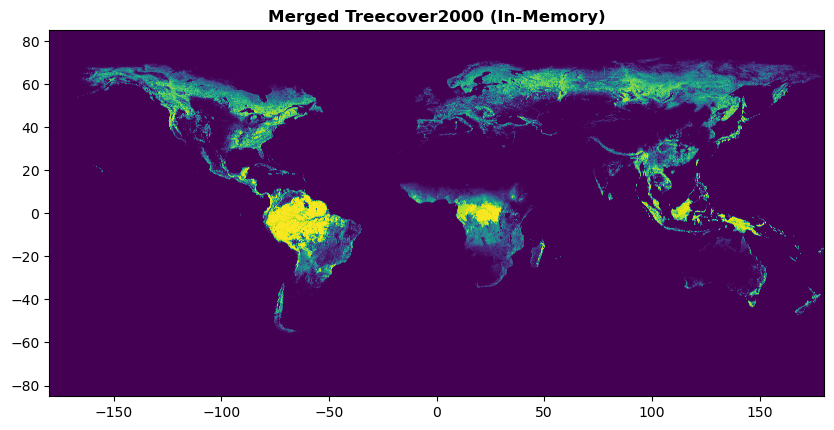

In [11]:
# Show the first band of the mosaic directly
fig, ax = plt.subplots(figsize=(10, 10))
show(mosaic, transform=out_trans, ax=ax, title="Merged Treecover2000 (In-Memory)")
plt.show()

In [12]:
# Threshold: create binary mask from mosaic
binary_mask = (mosaic[0] > 30).astype(np.uint8)  # 1 = forest, 0 = non-forest

# Save binary mask to a temporary raster file (needed for zonal_stats)
with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=binary_mask.shape[0],
        width=binary_mask.shape[1],
        count=1,
        dtype='uint8',
        transform=out_trans,
        crs='EPSG:4326' 
    ) as dataset:
        dataset.write(binary_mask, 1)

    # Compute zonal statistics using sum (since forest = 1, sum = count of pixels)
    stats = zonal_stats(
        ethnologue,
        memfile.name,
        stats=['sum'],
        geojson_out=True
    )

# Attach results to GeoDataFrame
ethnologue['treecover_pixels'] = [f['properties']['sum'] for f in stats]

# Calculate area in km² (each pixel = 0.01 km² at 100m resolution)
ethnologue['treecover_km2'] = ethnologue['treecover_pixels'] * 0.01

# View results
ethnologue[['ID', 'treecover_pixels', 'treecover_km2']].head()


c:\Users\juami\anaconda3\envs\geo\lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,ID,treecover_pixels,treecover_km2
0,RUS-RUS,6824037.0,68240.37
1,ENG-USA,2779872.0,27798.72
2,POR-BRA,3138134.0,31381.34
3,ENG-AUS,329626.0,3296.26
4,CMN-CHN,696454.0,6964.54


In [15]:
# List all the raster files (assuming they are .tif files)
raster_files = glob(str(hansen_path / "treeloss" / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

from rasterio.merge import merge

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

Found raster files: ['C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treeloss\\treeloss_100m_30m-0000000000-0000000000.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treeloss\\treeloss_100m_30m-0000000000-0000065536.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treeloss\\treeloss_100m_30m-0000000000-0000131072.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treeloss\\treeloss_100m_30m-0000000000-0000196608.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\Hansen_forest\\treeloss\\treeloss_100m_30m-0000000000-0000262144.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan

In [16]:
# Threshold: create binary mask from mosaic
binary_mask = mosaic[0].astype(np.uint8)  # 1 = forest, 0 = non-forest

# Save binary mask to a temporary raster file (needed for zonal_stats)
with MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=binary_mask.shape[0],
        width=binary_mask.shape[1],
        count=1,
        dtype='uint8',
        transform=out_trans,
        crs='EPSG:4326'  # Replace if different
    ) as dataset:
        dataset.write(binary_mask, 1)

    # Compute zonal statistics using sum (since forest = 1, sum = count of pixels)
    stats = zonal_stats(
        ethnologue,
        memfile.name,
        stats=['sum'],
        geojson_out=True
    )

# Attach results to GeoDataFrame
ethnologue['treeloss_pixels'] = [f['properties']['sum'] for f in stats]

# Calculate area in km² (each pixel = 0.01 km² at 100m resolution)
ethnologue['treeloss_km2'] = ethnologue['treeloss_pixels'] * 0.01

# View results
ethnologue[['ID', 'treeloss_pixels', 'treeloss_km2']].head()

,ID,treeloss_pixels,treeloss_km2
0,RUS-RUS,543501.0,5435.01
1,ENG-USA,351076.0,3510.76
2,POR-BRA,474266.0,4742.66
3,ENG-AUS,95194.0,951.94
4,CMN-CHN,8600.0,86.00


In [17]:
df_ethnologue = ethnologue[['ID', 'treecover_pixels', 'treecover_km2', 'treeloss_pixels', 'treeloss_km2']]

df_ethnologue.head()

,ID,treecover_pixels,treecover_km2,treeloss_pixels,treeloss_km2
0,RUS-RUS,6824037.0,68240.37,543501.0,5435.01
1,ENG-USA,2779872.0,27798.72,351076.0,3510.76
2,POR-BRA,3138134.0,31381.34,474266.0,4742.66
3,ENG-AUS,329626.0,3296.26,95194.0,951.94
4,CMN-CHN,696454.0,6964.54,8600.0,86.00


In [18]:
len(df_ethnologue)

7087

In [19]:
# Export to CSV
df_ethnologue.to_csv(hansen_path / "ethnologue_treecoverloss.csv", index=False)

print(f"Exported df_ethnologue.csv")

Exported df_ethnologue.csv
